In [1]:
import argparse
import pickle
import random
from sentence_transformers import SentenceTransformer
from sklearn.cluster import HDBSCAN, DBSCAN, KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import os
import matplotlib.pyplot as plt



# bigger/different embedding model
# - Qwen/Qwen3-Embedding-0.6B
# - nvidia/llama-3.2-nv-embedqa-1b-v2
# - Qwen/Qwen3-Embedding-4B
# - tencent/Youtu-Embedding

# filter non-constructive

# generate headings

# ranking for leader selection

# integrate

CORPORA_PROMPTS = {
    "what_blocks_you": "What is currently blocking you the most in your daily work?",
    "office_trash_solutions": "How should we solve the issue of trash piling up in the office?",
}

CORPORA = {
    "what_blocks_you": [
        "spontanious calls",
        "My coworkers distracting me, hate em",
        "loud office environment",
        "Getting distracted by social media and friends",
        "loud noisy people",
        "ci is incredibly slow. it takes half a day to run our test suite!",
        "meetings are scheduled back to back, making everyone late",
        "Hardware is stopping working",
        "Transportation and information flow sucks",
        "🍉🍔🍟🤤",
        "When I did not sleep well last night. I am just tired and cannot focus at all. Sometimes there are street workers near my home and they always wake me up.",
        "it support is incredibly slow. it can take weeks to get some software installed",
        "Coworkers being suspicously sick",
        "waiting for code reviews that take days to get feedback",
        "constant context switching between different projects",
        "unclear requirements that keep changing mid-sprint",
        "outdated documentation that doesn't match the current system",
        "legacy code that's impossible to understand or modify",
        "slow internet connection making everything take forever",
        "having to attend too many status meetings with no clear agenda",
        "tools and systems that crash frequently during peak hours",
        "lack of proper development environment setup",
        "dependencies on other teams that never respond on time",
        "debugging production issues with no logging or monitoring",
        "manual deployment processes that break half the time",
        "working with APIs that have poor or missing documentation",
        "password and access management that takes weeks to resolve",
        "having to use multiple different tools that don't integrate well"
    ],
    "office_trash_solutions": [
        "add more trash bins around the office",
        "hire a cleaning service that comes twice a day",
        "set up recycling stations with clear labels",
        "send weekly reminders to clean up after yourself",
        "designate someone as office cleanliness coordinator",
        "install bigger trash cans in high-traffic areas",
        "create a rotating cleanup schedule for all employees",
        "put trash bins next to every desk and workstation",
        "organize monthly office cleaning days with pizza",
        "implement a 'clean desk policy' at end of day",
        "add compost bins for food waste",
        "place hand sanitizer stations near all trash areas",
        "create incentives for keeping common areas clean",
        "install motion sensor trash cans that open automatically",
        "set up a system where messiest area gets called out weekly",
        "provide more paper towels and cleaning supplies",
        "establish clear rules about personal food storage",
        "create designated eating areas only",
        "add more frequent building maintenance visits",
        "install better ventilation to reduce odors from trash"
    ]
}

def hdbscan_clustering(embeddings):
    clusterer = HDBSCAN(min_samples=2, min_cluster_size=2, max_cluster_size=5, cluster_selection_method="leaf",
                       allow_single_cluster=False, metric="cosine")
    return clusterer.fit_predict(embeddings)

def hdbscan_clustering_manhattan(embeddings):
    clusterer = HDBSCAN(min_samples=2, min_cluster_size=2, cluster_selection_method="leaf",
                       allow_single_cluster=True, metric="manhattan")
    return clusterer.fit_predict(embeddings)

def dbscan_clustering(embeddings):
    clusterer = DBSCAN(eps=0.5, min_samples=2, metric="cosine")
    return clusterer.fit_predict(embeddings)

def kmeans_clustering(embeddings, n_clusters=5):
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    return clusterer.fit_predict(embeddings)

def agglomerative_clustering(embeddings, n_clusters=5):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    return clusterer.fit_predict(embeddings)

def tsne_hdbscan_clustering(embeddings):
    tsne = TSNE(n_components=3, perplexity=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return hdbscan_clustering(reduced_embeddings)

CLUSTERING_ALGORITHMS = {
    "hdbscan": hdbscan_clustering,
    "hdbscan_clustering_manhattan": hdbscan_clustering_manhattan,
    "dbscan": dbscan_clustering,
    "kmeans": kmeans_clustering,
    "agglomerative": agglomerative_clustering,
    "tsne_hdbscan": tsne_hdbscan_clustering
}



In [2]:
texts_with_cat = {
    "texts": [
        "The food is bad and I'm allergic", "The spaghetti aren't well cooked", 'I do not like the food', "The coffee machine doesn't work", 'The kitchen is always too hot or too cold', "I've found mold in the fridge", "I'm allergic to something in the cafeteria", 'The lunch break is too short', "The shower doesn't have enough pressure", 'The shower is dirty', "The water isn't hot enough in the shower", "I don't like the bathroom layout", "There's no soap in the restroom", 'I like my co-worker Jeff', 'I get harassed in the shower by my coworkers', 'My boss is a prick', 'I get too many emails about work during my free time', 'My co-worker often interrupts me in meetings', "I've noticed a coworker stealing office supplies", 'The office dress code is too restrictive', 'I have to walk 30 minutes from the train station', "There aren't enough parking spaces", 'My commute is too long and tiring', 'The bus is always late', 'The car park is overcrowded', 'The elevator breaks down frequently', 'The parking lot is poorly lit at night', 'My bike is damaged in the parking area', "The chairs aren't comfortable", 'My PC is slow', "I'm pretty sure my desk changes height over night", 'I want a new chair because my doctor told me I need one', 'My laptop is slow', 'My chair causes back pain', 'The PC monitor is too small', 'The keyboard is old and sticky', 'I need a new mouse because the current one is broken', "The security isn't good enough", 'The security guard sleeps in his chair', "The company doesn't provide enough safety training", 'The front door is always unlocked', "The security cameras don't work in certain areas", "The company doesn't have a clear emergency plan", "The fire alarm system doesn't work properly", "I've seen unauthorized people in the office building"
    ],
    "categories": [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5]
}





In [3]:
list(
sorted(zip(texts_with_cat['texts'], texts_with_cat['categories']), key=lambda x: x[1])
)

[("The food is bad and I'm allergic", 0),
 ("The spaghetti aren't well cooked", 0),
 ('I do not like the food', 0),
 ("The coffee machine doesn't work", 0),
 ('The kitchen is always too hot or too cold', 0),
 ("I've found mold in the fridge", 0),
 ("I'm allergic to something in the cafeteria", 0),
 ('The lunch break is too short', 0),
 ("The shower doesn't have enough pressure", 1),
 ('The shower is dirty', 1),
 ("The water isn't hot enough in the shower", 1),
 ("I don't like the bathroom layout", 1),
 ("There's no soap in the restroom", 1),
 ('I like my co-worker Jeff', 2),
 ('I get harassed in the shower by my coworkers', 2),
 ('My boss is a prick', 2),
 ('I get too many emails about work during my free time', 2),
 ('My co-worker often interrupts me in meetings', 2),
 ("I've noticed a coworker stealing office supplies", 2),
 ('The office dress code is too restrictive', 2),
 ('I have to walk 30 minutes from the train station', 3),
 ("There aren't enough parking spaces", 3),
 ('My comm

In [4]:
len(texts_with_cat['texts'])

45

In [5]:
len(texts_with_cat['categories'])

45

In [6]:
model_name = 'nvidia/llama-3.2-nv-embedqa-1b-v2'
pickle_dir='/state'
corpus_name='what_blocks_you'
# texts = CORPORA[corpus_name].copy()

In [7]:
texts = texts_with_cat['texts']
texts

["The food is bad and I'm allergic",
 "The spaghetti aren't well cooked",
 'I do not like the food',
 "The coffee machine doesn't work",
 'The kitchen is always too hot or too cold',
 "I've found mold in the fridge",
 "I'm allergic to something in the cafeteria",
 'The lunch break is too short',
 "The shower doesn't have enough pressure",
 'The shower is dirty',
 "The water isn't hot enough in the shower",
 "I don't like the bathroom layout",
 "There's no soap in the restroom",
 'I like my co-worker Jeff',
 'I get harassed in the shower by my coworkers',
 'My boss is a prick',
 'I get too many emails about work during my free time',
 'My co-worker often interrupts me in meetings',
 "I've noticed a coworker stealing office supplies",
 'The office dress code is too restrictive',
 'I have to walk 30 minutes from the train station',
 "There aren't enough parking spaces",
 'My commute is too long and tiring',
 'The bus is always late',
 'The car park is overcrowded',
 'The elevator breaks d

In [8]:
def embed_stage_categ(texts_with_cat, model_name, pickle_dir, corpus_name):
    texts = texts_with_cat['texts']
    categories = texts_with_cat['categories']

    pickle_file = os.path.join(pickle_dir, f"{corpus_name}.pkl")

    print(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name, trust_remote_code=True)
    print(f"Encoding {len(texts)} texts...")
    embeddings = model.encode(texts)

    print(f"Saving embeddings to {pickle_file}")
    os.makedirs(pickle_dir, exist_ok=True)
    with open(pickle_file, 'wb') as f:
        pickle.dump({'embeddings': embeddings, 'texts': texts, 'categories': categories}, f)

    print(f"Embeddings saved. Shape: {embeddings.shape}")

embed_stage_categ(texts_with_cat, model_name, pickle_dir, corpus_name)

No sentence-transformers model found with name nvidia/llama-3.2-nv-embedqa-1b-v2. Creating a new one with mean pooling.


Loading model: nvidia/llama-3.2-nv-embedqa-1b-v2
Encoding 45 texts...
Saving embeddings to /state/what_blocks_you.pkl
Embeddings saved. Shape: (45, 2048)


In [9]:

def rate_clustering_quality(cluster_labels, true_labels):
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    # print(f"Clustering Quality → ARI: {ari:.3f}, NMI: {nmi:.3f}")
    return round(ari,3), round(nmi,3)


In [10]:

pickle_file = os.path.join(pickle_dir, f"{corpus_name}.pkl")

print(f"Loading embeddings from {pickle_file}")
with open(pickle_file, 'rb') as f:
    data = pickle.load(f)

embeddings = data['embeddings']
texts = data['texts']
true_labels = data['categories']

Loading embeddings from /state/what_blocks_you.pkl


In [11]:
algorithm_to_label = {}
algorithm_to_score = {}

for algorithm in CLUSTERING_ALGORITHMS:
    # print(f"\nRunning {algorithm} clustering...")
    labels = CLUSTERING_ALGORITHMS[algorithm](embeddings)
    algorithm_to_label[algorithm] = labels
    # print(f"Clustering results ({algorithm}):")

    # Get the (score, other_metric)
    ari_score, nmi_score = rate_clustering_quality(cluster_labels=labels, true_labels=true_labels)
    algorithm_to_score[algorithm] = (ari_score, nmi_score)

    # print("-" * 50)

# Sort by score descending
sorted_algorithms = sorted(algorithm_to_score.items(), key=lambda x: x[1][0], reverse=True)

print("\n=== Algorithms sorted by score ===")
for algo, (ari_score, nmi_score) in sorted_algorithms:
    print(f"{algo}: ari={ari_score}, nmi={nmi_score}")



=== Algorithms sorted by score ===
agglomerative: ari=0.2, nmi=0.409
hdbscan: ari=0.136, nmi=0.507
hdbscan_clustering_manhattan: ari=0.09, nmi=0.435
kmeans: ari=0.088, nmi=0.266
tsne_hdbscan: ari=0.054, nmi=0.424
dbscan: ari=0.0, nmi=0.0


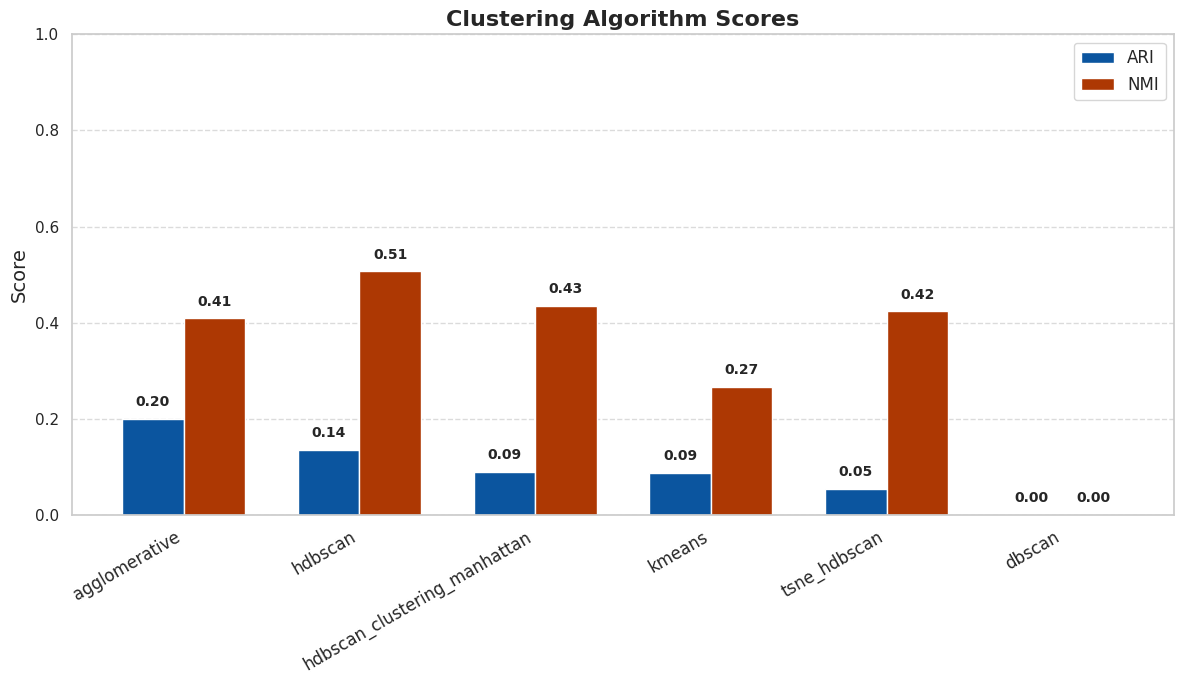

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example: sorted_algorithms = [("KMeans", (0.45, 0.52)), ("Agglomerative", (0.50, 0.55)), ("DBSCAN", (0.38, 0.40))]
algorithms = [algo for algo, _ in sorted_algorithms]
ari_scores = [scores[0] for _, scores in sorted_algorithms]
nmi_scores = [scores[1] for _, scores in sorted_algorithms]

x = np.arange(len(algorithms))  # positions for groups
width = 0.35  # width of bars

# Set a nicer style
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, ari_scores, width, label='ARI', color=sns.color_palette("Blues")[5])
rects2 = ax.bar(x + width/2, nmi_scores, width, label='NMI', color=sns.color_palette("Oranges")[5])

# Titles and labels
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Clustering Algorithm Scores', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, rotation=30, ha='right', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(fontsize=12)

# Add value labels on top of bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10, weight='bold')

# Optional: add horizontal grid lines for easier comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


# Viz

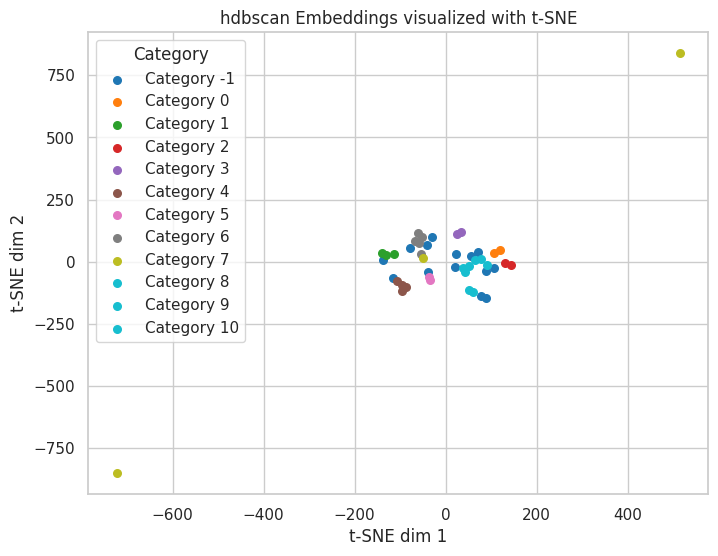

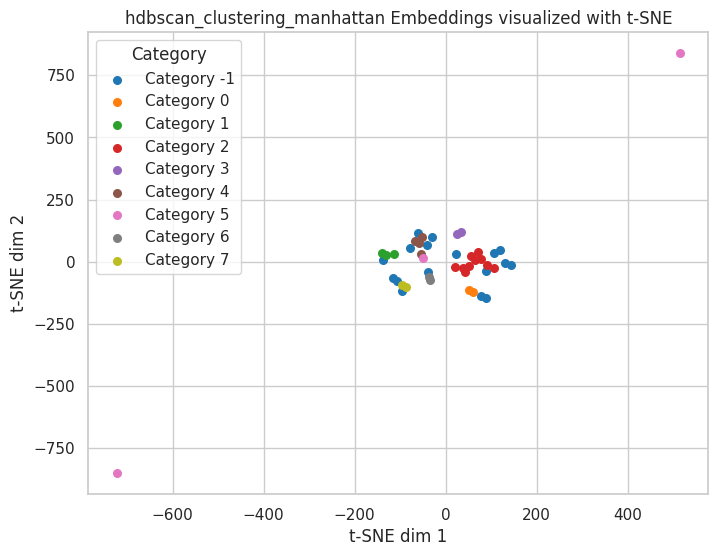

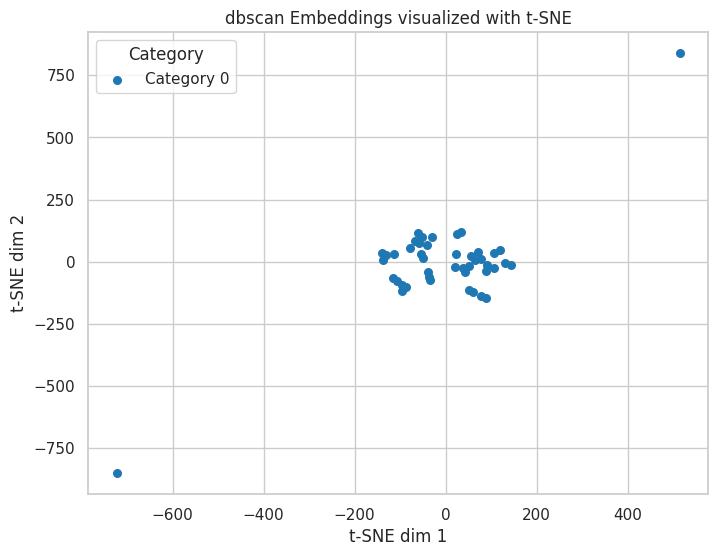

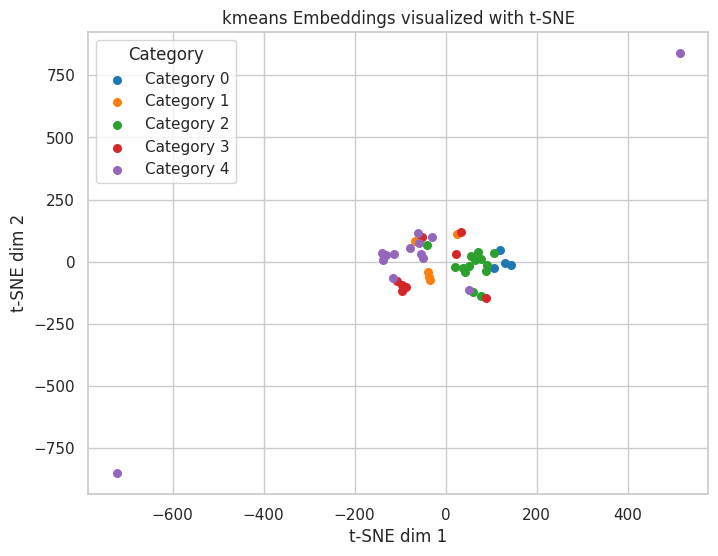

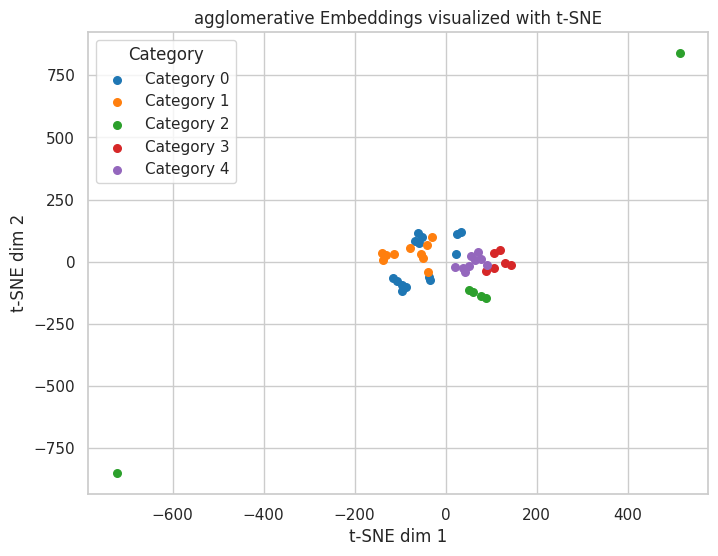

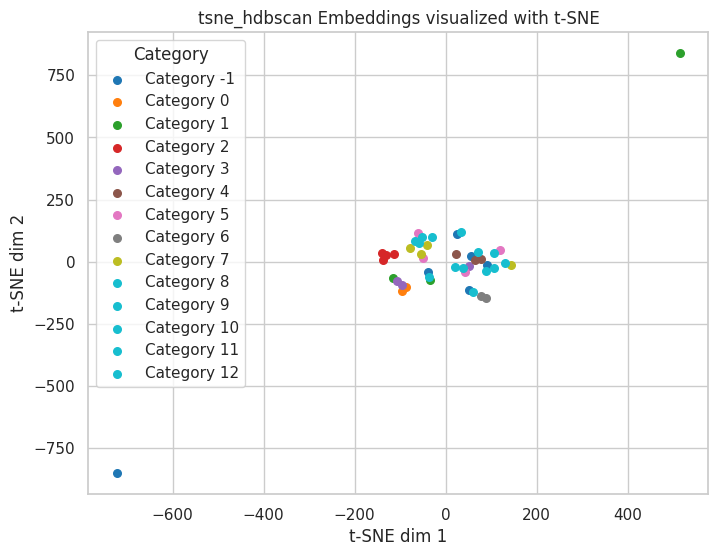

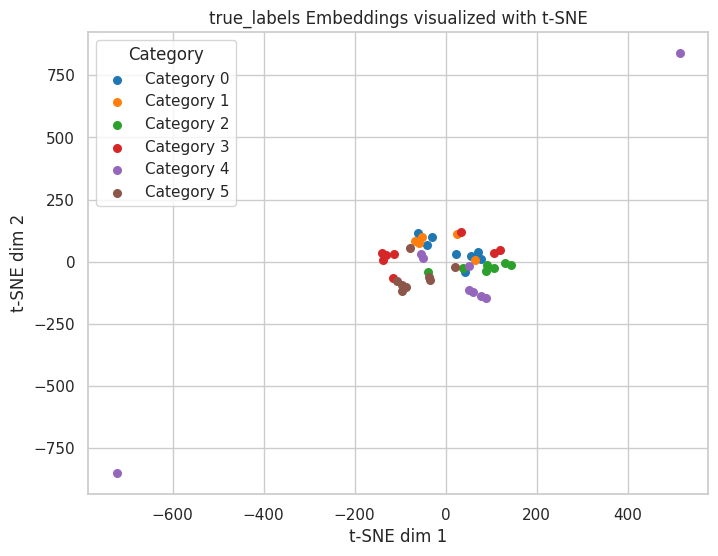

In [13]:
algorithm_to_label['true_labels'] = true_labels
for algorithm, labels in algorithm_to_label.items():
    tsne = TSNE(n_components=2, random_state=42, perplexity=3)
    emb_2d = tsne.fit_transform(embeddings)

    categories = np.unique(labels)
    colors = plt.cm.tab10(np.arange(len(categories)))  # pick distinct colors

    plt.figure(figsize=(8,6))

    for cat, color in zip(categories, colors):
        idx = np.array(labels) == cat
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], c=[color], label=f'Category {cat}', s=30)

    plt.title(f"{algorithm} Embeddings visualized with t-SNE")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend(title="Category")
    plt.show()
